## Data Load 

In [2]:
import numpy as np
import pandas as pd
import regex
import re
from PIL import Image
import torch
from torchvision.transforms import v2
from tqdm import tqdm
import os

from collections import Counter
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib


In [3]:
# config에서 data 폴더 경로 가져오기
data_dir = "/data/ephemeral/home/data"  # 예: "config/data"

# users.csv 경로 만들기
user_data_path = os.path.join(data_dir, "users.csv")
user_df = pd.read_csv(user_data_path)

book_data_path = os.path.join(data_dir, "books.csv")
book_df = pd.read_csv(book_data_path)

train_rating_data_path = os.path.join(data_dir, "train_ratings.csv")
train_rating_df = pd.read_csv(train_rating_data_path)

In [5]:
full_df = train_rating_df.merge(
    user_df,
    on="user_id",
    how="left"
)

# -----------------------
# 5. Merge: book 정보 추가
# -----------------------
full_df = full_df.merge(
    book_df,
    on="isbn",
    how="left"
)

print("Full DF shape:", full_df.shape)
print("full_df 의 columns:", full_df.columns)

Full DF shape: (306795, 14)
full_df 의 columns: Index(['user_id', 'isbn', 'rating', 'location', 'age', 'book_title',
       'book_author', 'year_of_publication', 'publisher', 'img_url',
       'language', 'category', 'summary', 'img_path'],
      dtype='object')


In [25]:
book_df_eda = book_df.copy()
user_df_eda = user_df.copy()
train_rating_df_eda = train_rating_df.copy()
full_df_eda = full_df.copy()


## books_df 의 category 피쳐 분석하기

In [ ]:


# 이전 질문에서 정의된 문자열을 리스트로 변환하는 함수
def str2list(x: str) -> list:
    '''문자열을 리스트로 변환하는 함수'''
    # 양쪽 대괄호 제거 및 ', ' 기준으로 분할
    return x[1:-1].split(', ')

# --- 고유 카테고리 추출 코드 ---

# 1. 'category' 열의 결측치(NaN)가 아닌 값만 필터링합니다.
#    apply 메서드가 NaN 값에 대해 오류를 일으키지 않도록 방지합니다.
valid_categories = book_df['category'].dropna()

# 2. 모든 카테고리 문자열을 리스트로 변환하고 하나의 리스트로 합칩니다.
#    lambda x: str2list(x)는 각 문자열을 리스트로 변환하고,
#    sum(..., [])는 그 모든 리스트를 하나의 큰 리스트로 결합합니다.
# all_categories = valid_categories.apply(lambda x: str2list(x)).sum(start=[])
all_categories = sum(valid_categories.apply(lambda x: str2list(x)), start=[])
# 3. 합쳐진 리스트에서 고유한(distinct) 카테고리만 추출합니다.
distinct_categories = sorted(list(set(all_categories)))

# 4. 결과를 출력합니다.
print("--- book_df의 고유 카테고리 목록 (Distinct Categories) ---")
print(distinct_categories[:30])


print("--- str2list 역할 파악 ---")
# 이 코드 결과가 없음을 보면 -> str2list 는 그저 문자열을 리스트로 변환하기만 한다.
for category in distinct_categories:
    if len(str2list(category)) >= 2:
        print(str2list(category))

# -----------------------------------------------------------
# 5. 최종 요구사항 분석 및 출력
# -----------------------------------------------------------

# 5-1. 카테고리 빈도 분석 및 TOP 100 출력
category_counts = Counter(all_categories)
df_counts = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])
df_counts = df_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

total_category_instances = len(all_categories)
df_counts['Percentage'] = (df_counts['Count'] / total_category_instances) * 100

print(f"장르 종류 갯수: {len(distinct_categories)}개")
print(f"총 books.csv 총 데이터 갯수(결측치 제외): {total_category_instances}개")
print("\n[카테고리 등장 빈도 TOP 100 (상위 항목)]")
# Top 100 요청했으나, 데이터가 작으므로 전체 또는 상위 10개만 출력합니다.
top_n = min(100, len(df_counts))
print(df_counts.head(top_n).to_string(index=False, float_format="%.2f"))
print("-" * 50)


# 5-2. 분포 설명 및 이상치 카테고리 출력
# 이상치 정의: 전체 카테고리 중 단 1회만 등장한 카테고리
outlier_categories = df_counts[df_counts['Count'] == 1]

print(f"\n[카테고리 분포 분석]")
print(f"가장 많이 등장한 카테고리: {df_counts.iloc[0]['Category']} ({df_counts.iloc[0]['Count']}회)")
print(f"가장 적게 등장한 카테고리 (이상치): {outlier_categories.shape[0]}개")

if not outlier_categories.empty:
    print("\n[이상치 카테고리 목록 (1회 등장)]")
    # 이상치 목록이 너무 길 경우 10개만 출력
    print(", ".join(outlier_categories['Category'].tolist()[:10]))
print("-" * 50)

# 5-3. 카테고리 이름 글자수 분포 분석
df_distinct = pd.DataFrame({'Category': distinct_categories})
# 카테고리 이름 길이 계산 (공백 포함)
df_distinct['Length'] = df_distinct['Category'].apply(len)

length_stats = df_distinct['Length'].describe()
median_length = length_stats['50%']
std_dev = length_stats['std']

# 이상적으로 길거나 짧은 카테고리 정의 (중앙값 기준 ± 2*표준편차를 벗어나는 경우)
# 예시 데이터가 작으므로, 임의의 기준으로 설정: 짧음(5 미만), 김(15 초과)
SHORT_THRESHOLD = 5
LONG_THRESHOLD = 15

short_categories = df_distinct[df_distinct['Length'] < SHORT_THRESHOLD]
long_categories = df_distinct[df_distinct['Length'] > LONG_THRESHOLD]

print(f"\n[카테고리 이름 글자수 분포 분석]")
print(f"전체 고유 카테고리 수: {len(distinct_categories)}개")
print(f"카테고리 이름 길이 통계:\n{length_stats.to_string()}")

print(f"\n- 글자수가 {SHORT_THRESHOLD} 미만인 짧은 카테고리: {short_categories.shape[0]}개")
if not short_categories.empty:
    print(f"  목록 ({short_categories.shape[0]}개): {', '.join(short_categories['Category'].tolist())}")

print(f"- 글자수가 {LONG_THRESHOLD} 초과인 긴 카테고리: {long_categories.shape[0]}개")
if not long_categories.empty:
    print(f"  목록 ({long_categories.shape[0]}개): {', '.join(long_categories['Category'].tolist())}")
print("-" * 50)


--- book_df의 고유 카테고리 목록 (Distinct Categories) ---
['"ABC\'s"', '"Aesop\'s fables"', '"Almanacs', '"Alzheimer\'s disease"', '"April Fools\' Day"', '"Arthur Miller\'s The Crucible"', '"Artists\' books"', '"Artists\' contracts"', '"Artists\' models"', '"Artists\' representatives"', '"Artists\' spouses"', '"Author\'s spouses"', '"Authors\' spouses"', '"Blake\'s 7 (Television program)"', '"Bug\'s life (Motion picture)"', '"Chefs d\'orchestre - États-Unis - Biographies"', '"Children\'s accidents"', '"Children\'s art"', '"Children\'s atlases"', '"Children\'s audiobooks"', '"Children\'s costumes"', '"Children\'s detective and mystery stories"', '"Children\'s encyclopedias and dictionaries"', '"Children\'s fantasy fiction"', '"Children\'s films"', '"Children\'s literature', '"Children\'s literature"', '"Children\'s literature."', '"Children\'s paraphernalia"', '"Children\'s parties"']
--- str2list 역할 파악 ---
장르 종류 갯수: 4449개
총 books.csv 총 데이터 갯수: 83097개

[카테고리 등장 빈도 TOP 100 (상위 항목)]
             

### category 피쳐 결측치 title2genre 처리 -> bert 이용 임베딩 -> category_클러스터링(n 개의 범주로) 

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --------------------------------------------------
# 1. 모델 로드
# --------------------------------------------------
MODEL_NAME = "BEE-spoke-data/roberta-large-title2genre"

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model = model.to(device)
model.eval()

# --------------------------------------------------
# 2. category 결측치 예측 함수
# --------------------------------------------------
def fill_category_with_title2genre(book_df):
    df = book_df.copy()

    # category 결측치 인덱스
    mask = df["category"].isna() | (df["category"] == "")
    df_missing = df[mask]

    print(f"[INFO] category 결측치 개수: {len(df_missing)}")

    if len(df_missing) == 0:
        print("[INFO] 채울 category 결측치 없음")
        return df
    
    titles = df_missing["book_title"].tolist()

    preds = []
    batch_size = 16

    for i in range(0, len(titles), batch_size):
        batch = titles[i:i + batch_size]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            pred_ids = torch.argmax(probs, dim=1).cpu().numpy().tolist()

        # label id → label_name
        labels = [model.config.id2label[i] for i in pred_ids]
        preds.extend(labels)

    # --------------------------------------------------
    # 3. book_df에 결측치 채워넣기
    # --------------------------------------------------
    df.loc[mask, "category"] = preds

    print("[INFO] category 결측치 채우기 완료")

    return df

In [26]:
book_df_eda = fill_category_with_title2genre(book_df_eda)

[INFO] category 결측치 개수: 68851
[INFO] category 결측치 채우기 완료


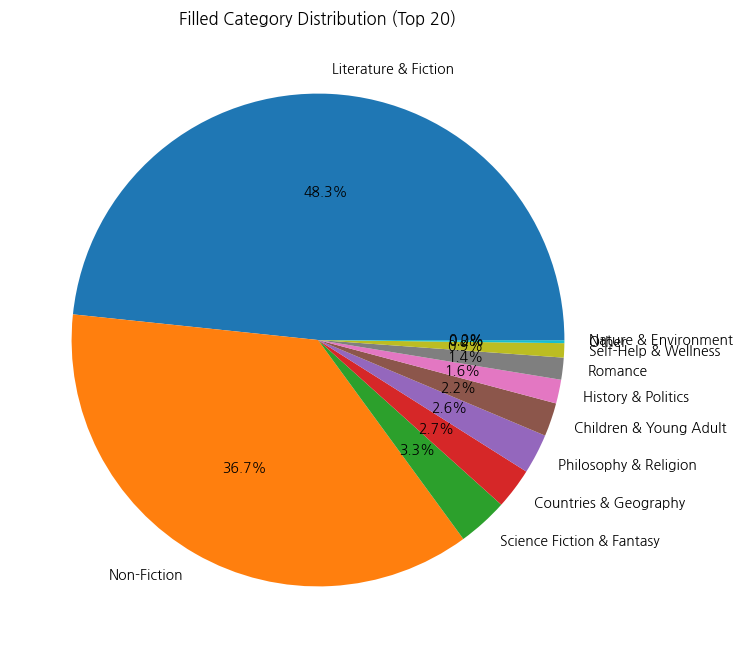

In [27]:
import matplotlib.pyplot as plt

df_before = book_df
df_after = book_df_eda

# 원래 category 결측치였던 row
mask_missing = df_before["category"].isna() | (df_before["category"] == "")
filled_df = df_after[mask_missing]

# 분포
vc = filled_df["category"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(vc, labels=vc_top.index, autopct='%1.1f%%')
plt.title(f"Filled Category Distribution (Top {top_n})")
plt.show()


In [33]:
import pandas as pd
import numpy as np
import re
import ast
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm import tqdm

# --------------------------------------------------
# 0. 리스트/문자열 혼종 category 정규화
# --------------------------------------------------
def normalize_category_text(x):
    """
    category 값이
    - list 문자열 "['a','b']"
    - list 객체
    - 단일 문자열 "fiction"
    모두 있을 수 있으므로 이를 순수 문자열로 변환
    """
    if pd.isna(x):
        return "unknown"

    x = str(x).strip()

    # 리스트 문자열 → 실제 리스트로 변환
    if (x.startswith("[") and x.endswith("]")):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return " ".join([str(p) for p in parsed])
        except:
            pass

    return x


# --------------------------------------------------
# 1. 카테고리 텍스트 전처리
# --------------------------------------------------
def preprocess_category(df, col='category', min_len=3):
    """
    category 텍스트 전처리:
    1) normalize_category_text 결과 입력
    2) 여러 구분자로 split
    3) 소문자 처리 & 공백 제거
    4) min_len 미만 'other'
    5) 다시 문장 형태 join
    """
    df[col] = df[col].fillna('unknown').astype(str)
    
    def clean_cat(x):
        x = x.strip().lower()

        # 여러 구분자 기준 split
        parts = re.split(r"[\/;:\|\>,\-\_\&\s]+", x)

        parts = [p.strip() for p in parts if p.strip() != ""]

        # 길이 필터링
        parts = [p if len(p) >= min_len else "other" for p in parts]

        if len(parts) == 0:
            return "unknown"

        return " ".join(parts)

    df[col] = df[col].apply(clean_cat)
    return df


# --------------------------------------------------
# 2. 텍스트 augmentation
# --------------------------------------------------
def augment_category_text(df, col='category'):
    df['category_text'] = df[col].apply(lambda x: f"Category: {x}")
    return df


# --------------------------------------------------
# 3. SBERT 임베딩
# --------------------------------------------------
def embed_categories(df, text_col='category_text', model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    categories = df[text_col].tolist()
    embeddings = model.encode(categories, batch_size=64, show_progress_bar=True)
    return np.array(embeddings)


# --------------------------------------------------
# 4. KMeans clustering
# --------------------------------------------------
def cluster_categories(embeddings, n_clusters=200, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    return kmeans.fit_predict(embeddings)


# --------------------------------------------------
# 5. 전체 파이프라인
# --------------------------------------------------

# 0) 리스트 기반 문자열 정규화
book_df_eda["category"] = book_df_eda["category"].apply(normalize_category_text)

# 1) 카테고리 전처리
book_df_eda = preprocess_category(book_df_eda, col='category', min_len=3)

# 2) SBERT-friendly 텍스트 생성
book_df_eda = augment_category_text(book_df_eda, col='category')

# 3) SBERT 임베딩
category_embeddings = embed_categories(
    book_df_eda,
    text_col='category_text',
    model_name='all-MiniLM-L6-v2'
)

# 4) 클러스터링
book_df_eda['category_cluster'] = cluster_categories(
    category_embeddings,
    n_clusters=200
)

# 5) 임시 컬럼 삭제
book_df_eda = book_df_eda.drop(columns=['category_text'])

# --------------------------------------------------
# 6. 결과 확인
# --------------------------------------------------
print(book_df_eda[['category', 'category_cluster']].head(10))


Batches:   0%|          | 0/2338 [00:00<?, ?it/s]

             category  category_cluster
0           actresses                49
1           1940 1949               135
2             medical                35
3             fiction                 0
4             history                16
5         non fiction                 3
6             fiction                 0
7             fiction                 0
8  literature fiction                 1
9  literature fiction                 1


In [30]:
# -------------------------------
# 8. 클러스터별 카테고리 확인
# -------------------------------

# cluster별로 대표 카테고리 확인
cluster_summary = book_df_eda.groupby('category_cluster')['category'].unique().reset_index()

# 보기 편하게 일부만 출력
pd.set_option('display.max_rows', 50)  # 필요시 조절
for idx, row in cluster_summary.iterrows():
    print(f"Cluster {row['category_cluster']}: {row['category']}")


Cluster 0: ["['fiction']" "['authors fiction']"]
Cluster 1: ["['body mind spirit']" "['mind and body']"]
Cluster 2: ['literature fiction']
Cluster 3: ['non fiction']
Cluster 4: ["['juvenile fiction']" "['young adult fiction']"
 "['juvenile science fiction']"
 "['best books for young adults (fiction)']"
 "['frontier and pioneer life manitoba juvenile fiction']"
 "['juvenile fiction nasty people pranks monkeys']"
 "['brothers and sisters juvenile fiction']"]
Cluster 5: ["['control (psychology)']" "['psychology']" "['child psychologists']"
 "['developmental psychology']" "['androgyny (psychology)']"
 "['change (psychology)']" "['child psychology']"
 "['human experimentation other psychology']" "['psychoanalysis']"
 "['chang (psychology)']" "['choice (psychology)']" "['sex (psychology)']"
 "['psychology applied']" "['cognitive psychology']"
 "['gestalt psychology']" "['psychologie sociale']"
 "['psychology pathological']" "['mood (psychology)']"
 "['clinical psychology']" "['stress (psycho

In [31]:
# -------------------------------
# 8. 클러스터별 데이터 개수 및 비율 확인
# -------------------------------

# cluster별 개수
cluster_counts = book_df_eda['category_cluster'].value_counts().sort_index()

# 전체 데이터 수
total_count = len(book_df_eda)

# 비율 계산
cluster_ratio = cluster_counts / total_count * 100

# 데이터프레임으로 보기 좋게 합치기
cluster_summary = pd.DataFrame({
    'count': cluster_counts,
    'ratio (%)': cluster_ratio
})

# 소수점 2자리로 포맷
cluster_summary['ratio (%)'] = cluster_summary['ratio (%)'].round(2)

print(cluster_summary)


                  count  ratio (%)
category_cluster                  
0                 33017      22.07
1                  1114       0.74
2                 33283      22.25
3                 25268      16.89
4                  5885       3.93
...                 ...        ...
195                 136       0.09
196                  42       0.03
197                  63       0.04
198                  28       0.02
199                  36       0.02

[200 rows x 2 columns]


## book_title-category-summary 관계 분석
- category 와 summary 약 45% 로 결측치가 비슷하던데 -> title 로 결측치 채우기 or Another
- cat_summ_clustering 만들고 -> x = book_title, y = cat_summ_clustering 하여, 40% 의 cat_summ_clustering 결측치 채우기.

## Book 과 Rating 간의 패턴 찾기

### 높은 평점을 가지는 책들 특징 찾기
- 💡 이 EDA로 어떤 인사이트를 얻을 수 있음?
- ✔ rating 1~5별로 어떤 cluster가 과대표집/과소대표집 되었는지

- → "rating 편향이 있는 장르" 확인 가능

- ✔ 특정 ISBN이 특정 rating에서 비정상적으로 많이 등장하면?

- → 모델이 해당 책을 bias있게 예측할 가능성 높음
- → cross-validation split 조정 필요

- ✔ rating별 popularity-normalized ranking

- → 추후 embedding / FM / CatBoost 모델에서 strong signal

In [ ]:
총 책 종류 갯수: len(book_df)
train data 에 있는 책 종류 갯수 : len(book_df)
Rating 별 unique 한 book 갯수(즉, 책 종류 갯수)
Rating 별 리뷰 갯수 
각 Rating 별 많이 등장한 isbn 과 해당 isbn 가지는 data 에 대한 설명 -> 이때 많이 등장한다 의 기준은 그책이 총 등장한 횟수와 비교해서 (이걸 고려안하면, 그냥 많이 등장하는 책이 모든 rating 다 잡아먹음)
각 Rating 별 많이 등장한 category_cluster



#### isbn 과 rating 관계

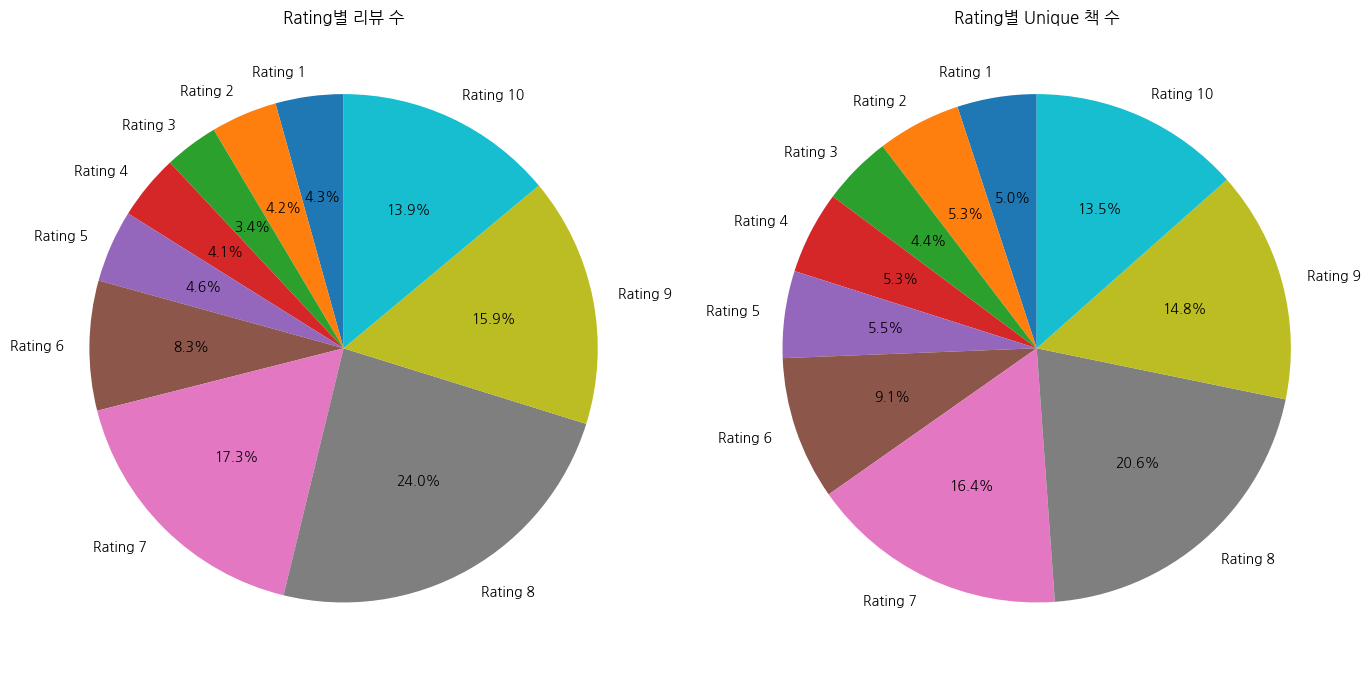

In [ ]:
import matplotlib.pyplot as plt

# ================================
# 0. 기본 세팅
# ================================
df = full_df_eda.copy()

df["rating"] = df["rating"].astype(int)

# ================================
# 1. Rating별 데이터 갯수
# ================================
rating_counts = df["rating"].value_counts().sort_index()

# ================================
# 2. Rating별 유니크 책 갯수
# ================================
rating_unique_books = df.groupby("rating")["isbn"].nunique()

# ================================
# 3. 두 개의 Pie Chart를 한 줄로 출력
# ================================
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# 왼쪽 - 리뷰 수 Pie
axes[0].pie(
    rating_counts,
    labels=[f"Rating {r}" for r in rating_counts.index],
    autopct="%1.1f%%",
    startangle=90
)
axes[0].set_title("Rating별 리뷰 수")

# 오른쪽 - 유니크 책 수 Pie
axes[1].pie(
    rating_unique_books,
    labels=[f"Rating {r}" for r in rating_unique_books.index],
    autopct="%1.1f%%",
    startangle=90
)
axes[1].set_title("Rating별 Unique 책 수")

plt.tight_layout()
plt.show()


1.0 2.0 1.0

[Info] IQR 필터링 경계값: 최소 1.0 회 이상 등장한 책만 사용

[결과] Rating별 비율 기반 Top-N 책 (필터링 적용)
    rating        isbn  rating_count  total_count  ratio
0        1  0002231352             1            1    1.0
1        1  0002237857             1            1    1.0
2        1  0002243016             1            1    1.0
3        1  0004102169             1            1    1.0
4        1  0006163831             1            1    1.0
5        2  0001053744             1            1    1.0
6        2  0001841572             1            1    1.0
7        2  0002163578             1            1    1.0
8        2  0002176432             2            2    1.0
9        2  0002255006             1            1    1.0
10       3  0001053736             1            1    1.0
11       3  0002255103             1            1    1.0
12       3  0006385648             1            1    1.0
13       3  0006498035             2            2    1.0
14       3  0007117507             1            1    

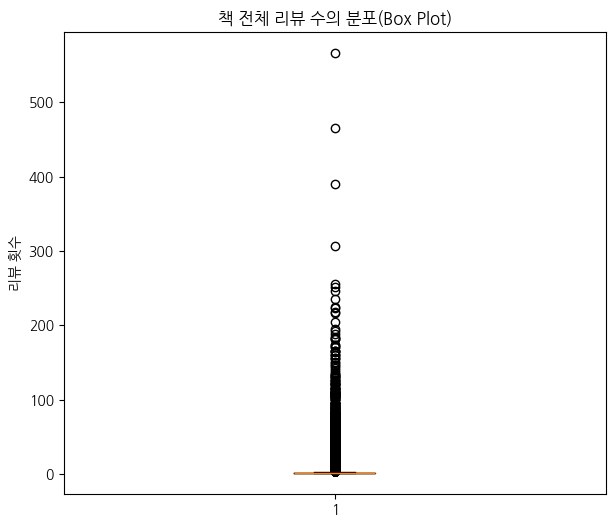

In [32]:
# 목적 :" 충분히 많은 리뷰를 가진 책들 중에서 특정 rating에 비정상적으로 많이 등장한 책을 찾는다."
# = ===============================
# 3. Rating별 Top-N 책 (비율 기반)
#    rating 내 등장 횟수 / 책 전체 등장 횟수
# ================================

df = full_df.copy()
df["rating"] = df["rating"].astype(int)

# =====================================
# A. 책 전체 등장 횟수 계산
# =====================================
isbn_total_count = df["isbn"].value_counts()

# =====================================
# B. IQR 기반 최소 리뷰수 필터링
# =====================================
Q1 = isbn_total_count.quantile(0.25)
Q3 = isbn_total_count.quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(1, Q1 - 1.5 * IQR)  # 음수 방지

print(Q1, Q3, IQR)

print(f"\n[Info] IQR 필터링 경계값: 최소 {lower_bound:.1f} 회 이상 등장한 책만 사용")

valid_isbns = isbn_total_count[isbn_total_count >= lower_bound].index

# 전체에서 valid_isbn만 유지
df_valid = df[df["isbn"].isin(valid_isbns)]
isbn_total_count_valid = df_valid["isbn"].value_counts()

# =====================================
# C. rating별 등장 횟수
# =====================================
isbn_rating_count = (
    df_valid.groupby(["rating", "isbn"])
    .size()
    .rename("rating_count")
    .reset_index()
)

isbn_rating_count["total_count"] = isbn_rating_count["isbn"].map(isbn_total_count_valid)
isbn_rating_count["ratio"] = isbn_rating_count["rating_count"] / isbn_rating_count["total_count"]

# =====================================
# D. Rating별 Top-N 선정
# =====================================
N = 5  # 기본값, 아래에서 근거 설명함

top_ratio_books = (
    isbn_rating_count
    .sort_values(["rating", "ratio"], ascending=[True, False])
    .groupby("rating")
    .head(N)
    .reset_index(drop=True)
)

# =====================================
# E. 결과 출력 (책 정보 제외)
# =====================================
print("\n[결과] Rating별 비율 기반 Top-N 책 (필터링 적용)")
print(top_ratio_books[[
    "rating",
    "isbn",
    "rating_count",
    "total_count",
    "ratio"
]])

# =====================================
# F. 상자그림 (책 전체 등장수 분포)
# =====================================
plt.figure(figsize=(7, 6))
plt.boxplot(isbn_total_count, vert=True)
plt.title("책 전체 리뷰 수의 분포(Box Plot)")
plt.ylabel("리뷰 횟수")
plt.show()

In [33]:
import pandas as pd
import numpy as np

# 책별 리뷰 카운트
book_review_counts = full_df["isbn"].value_counts()

# 최대값 확인
max_count = book_review_counts.max()
print("최대 리뷰 수:", max_count)

# 100 단위 bins 생성
bin_edges = list(range(0, int(max_count) + 100, 100))  # 예: 0,100,200,...600

# 마지막 구간을 “이상”으로 보기 위해 라벨 생성
bin_labels = []
for i in range(len(bin_edges) - 1):
    bin_labels.append(f"{bin_edges[i]} ~ {bin_edges[i+1]-1}")
bin_labels[-1] = f"{bin_edges[-2]}+"  # 마지막 구간 500+ 형태로 표현

# pd.cut으로 구간 나누기
book_bins = pd.cut(
    book_review_counts,
    bins=bin_edges,
    labels=bin_labels,
    right=False  # [0,100), [100,200) 형태
)

# 구간별 책 개수
bin_counts = book_bins.value_counts().sort_index()
print("\n=== 리뷰 수 구간별 책 개수 ===")
print(bin_counts)


최대 리뷰 수: 566

=== 리뷰 수 구간별 책 개수 ===
count
0 ~ 99       129680
100 ~ 199        84
200 ~ 299         9
300 ~ 399         2
400 ~ 499         1
500+              1
Name: count, dtype: int64


In [34]:
import pandas as pd
import numpy as np

# 책별 리뷰 카운트
book_review_counts = full_df["isbn"].value_counts()

# 0~99 중에서 10 단위 bin 생성
bin_edges_10 = list(range(0, 110, 10))   # 0,10,20,...100

# 라벨 생성
bin_labels_10 = [f"{i}~{i+9}" for i in range(0, 100, 10)]

# 0~99까지만 필터링 (100 이상은 제외)
mask_0_99 = book_review_counts[book_review_counts < 100]

# pd.cut으로 구간 나누기
book_bins_10 = pd.cut(
    mask_0_99,
    bins=bin_edges_10,
    labels=bin_labels_10,
    right=False   # [0,10), [10,20) ...
)

# 구간별 책 개수
bin_counts_10 = book_bins_10.value_counts().sort_index()

print("\n=== 0~99 리뷰 수 책들을 10단위로 자른 구간별 책 개수 ===")
print(bin_counts_10)



=== 0~99 리뷰 수 책들을 10단위로 자른 구간별 책 개수 ===
count
0~9      125701
10~19      2571
20~29       677
30~39       297
40~49       180
50~59        95
60~69        57
70~79        59
80~89        27
90~99        16
Name: count, dtype: int64


### rating 과 category, category_cluster 관계

In [34]:
full_df_eda = train_rating_df.merge(
    user_df_eda,
    on="user_id",
    how="left"
)

# -----------------------
# 5. Merge: book 정보 추가
# -----------------------
full_df_eda = full_df_eda.merge(
    book_df_eda,
    on="isbn",
    how="left"
)

print("Full DF shape:", full_df_eda.shape)
print("full_df 의 columns:", full_df_eda.columns)

Full DF shape: (306795, 15)
full_df 의 columns: Index(['user_id', 'isbn', 'rating', 'location', 'age', 'book_title',
       'book_author', 'year_of_publication', 'publisher', 'img_url',
       'language', 'category', 'summary', 'img_path', 'category_cluster'],
      dtype='object')


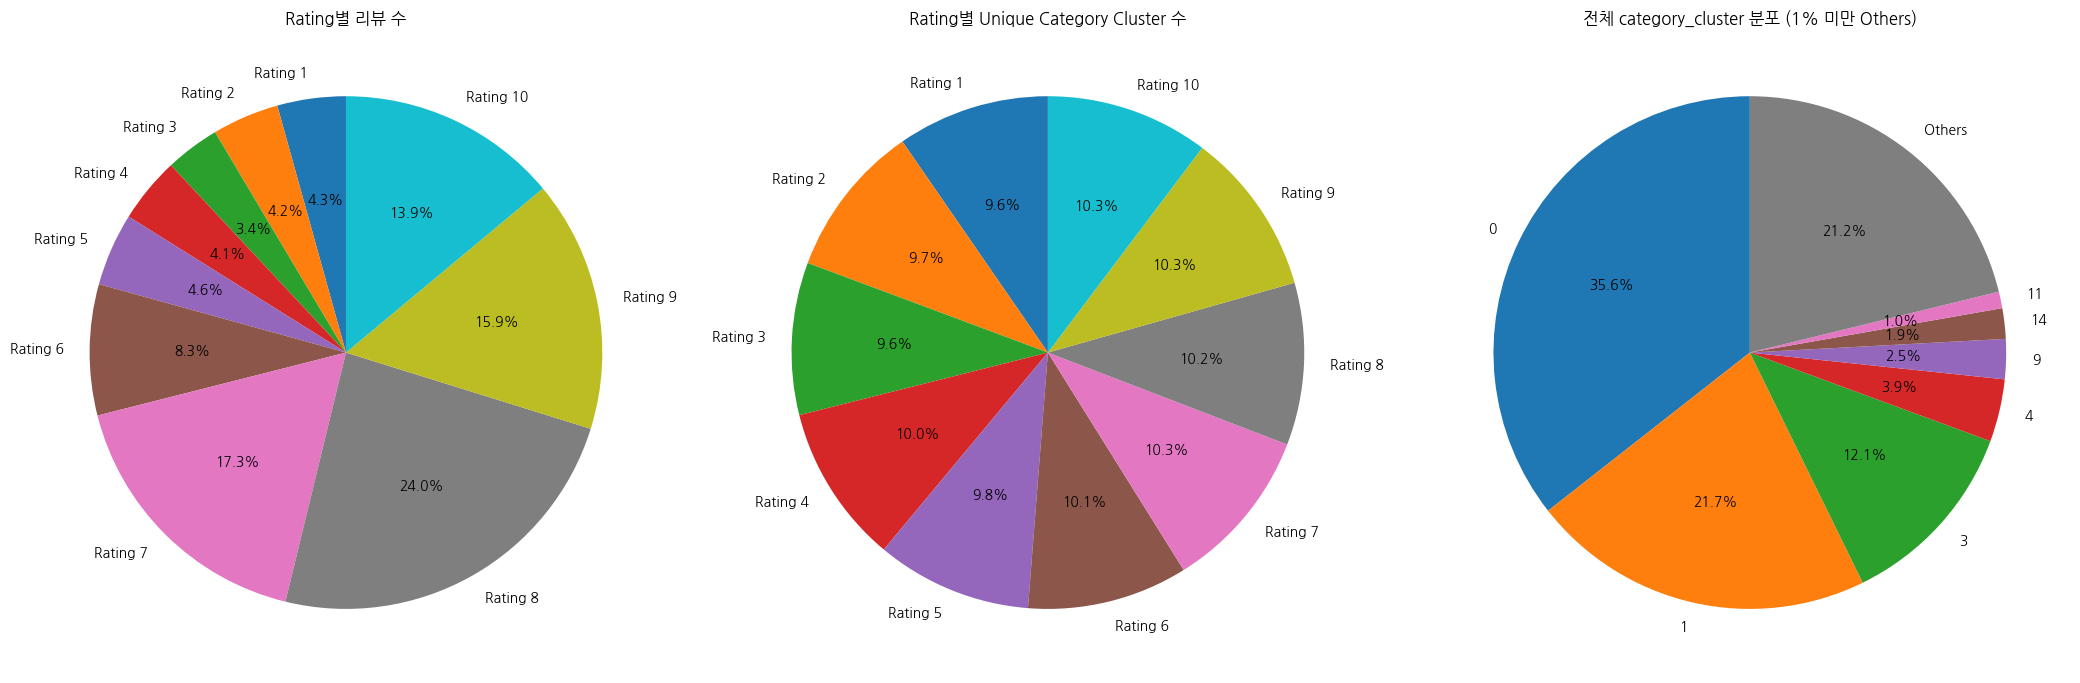

In [35]:
import matplotlib.pyplot as plt

# ------------------------------
# Pie chart용 데이터 변환 (1% 미만 Others)
# ------------------------------
def prepare_pie_data_for_chart(count_series, threshold=0.01):
    total = count_series.sum()
    ratio = count_series / total

    large = count_series[ratio >= threshold]
    small = count_series[ratio < threshold]

    if len(small) > 0:
        large["Others"] = small.sum()

    return large


# ================================
# 0. 기본 세팅
# ================================
df = full_df_eda.copy()
df["rating"] = df["rating"].astype(int)

# ================================
# 1. Rating별 데이터 갯수 (리뷰 수)
# ================================
rating_counts = df["rating"].value_counts().sort_index()

# ================================
# 2. Rating별 Unique category_cluster 수
# ================================
rating_unique_clusters = df.groupby("rating")["category_cluster"].nunique()

# ================================
# 3. 전체 category_cluster 분포
# ================================
cluster_counts = df["category_cluster"].value_counts()
cluster_counts_pie = prepare_pie_data_for_chart(cluster_counts)

# ================================
# 4. Pie Charts 한 줄로 출력 (1 x 3)
# ================================
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# 왼쪽 - Rating별 리뷰 수
axes[0].pie(
    rating_counts,
    labels=[f"Rating {r}" for r in rating_counts.index],
    autopct="%1.1f%%",
    startangle=90
)
axes[0].set_title("Rating별 리뷰 수")

# 가운데 - Rating별 Unique Category Cluster
axes[1].pie(
    rating_unique_clusters,
    labels=[f"Rating {r}" for r in rating_unique_clusters.index],
    autopct="%1.1f%%",
    startangle=90
)
axes[1].set_title("Rating별 Unique Category Cluster 수")

# 오른쪽 - 전체 category_cluster 분포 (1% 미만 Others)
axes[2].pie(
    cluster_counts_pie,
    labels=cluster_counts_pie.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[2].set_title("전체 category_cluster 분포 (1% 미만 Others)")

plt.tight_layout()
plt.show()


86.0 151.5 364.5 278.5

[Info] IQR 필터링 경계값: 최소 1.0 회 이상 등장한 category_cluster만 분석 대상으로 사용

[결과] Rating별 비율 기반 Top-N category_cluster (필터링 적용)
    rating  category_cluster  rating_count  total_count     ratio
0        1               192             4           29  0.137931
1        1                92            24          178  0.134831
2        1                98             9           76  0.118421
3        1                37             6           56  0.107143
4        1               191             3           29  0.103448
5        2               184             3            8  0.375000
6        2               110             7           52  0.134615
7        2               167            12           94  0.127660
8        2               189             6           53  0.113208
9        2                68            14          128  0.109375
10       3               110             7           52  0.134615
11       3               100             2           20  0.100000
1

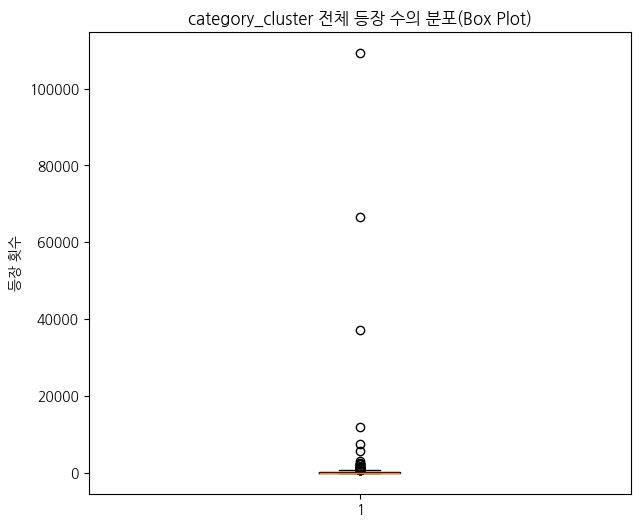

In [38]:
import matplotlib.pyplot as plt

# =====================================
# 0. 기본 세팅
# =====================================
df = full_df_eda.copy()
df["rating"] = df["rating"].astype(int)

# =====================================
# A. cluster 전체 등장 횟수 계산
# =====================================
cluster_total_count = df["category_cluster"].value_counts()

# =====================================
# B. IQR 기반 최소 등장수 필터링
# =====================================
Q1 = cluster_total_count.quantile(0.25)
Q3 = cluster_total_count.quantile(0.75)
median = cluster_total_count.quantile(0.5)
IQR = Q3 - Q1
lower_bound = max(1, Q1 - 1.5 * IQR)

print(Q1, median, Q3, IQR)
print(f"\n[Info] IQR 필터링 경계값: 최소 {lower_bound:.1f} 회 이상 등장한 category_cluster만 분석 대상으로 사용")

valid_clusters = cluster_total_count[cluster_total_count >= lower_bound].index

# 전체에서 valid cluster만 유지
df_valid = df[df["category_cluster"].isin(valid_clusters)]
cluster_total_count_valid = df_valid["category_cluster"].value_counts()

# =====================================
# C. rating별 cluster 등장 횟수 계산
# =====================================
cluster_rating_count = (
    df_valid.groupby(["rating", "category_cluster"])
    .size()
    .rename("rating_count")
    .reset_index()
)

# 클러스터 전체 등장수 매핑
cluster_rating_count["total_count"] = cluster_rating_count["category_cluster"].map(cluster_total_count_valid)

# 비율 계산
cluster_rating_count["ratio"] = cluster_rating_count["rating_count"] / cluster_rating_count["total_count"]

# =====================================
# D. Rating별 Top-N 선정
# =====================================
N = 5

top_ratio_clusters = (
    cluster_rating_count
    .sort_values(["rating", "ratio"], ascending=[True, False])
    .groupby("rating")
    .head(N)
    .reset_index(drop=True)
)

# =====================================
# E. 결과 출력
# =====================================
print("\n[결과] Rating별 비율 기반 Top-N category_cluster (필터링 적용)")
print(top_ratio_clusters[[
    "rating",
    "category_cluster",
    "rating_count",
    "total_count",
    "ratio"
]])

# =====================================
# F. 상자그림 (클러스터 전체 등장수 분포)
# =====================================
plt.figure(figsize=(7, 6))
plt.boxplot(cluster_total_count, vert=True)
plt.title("category_cluster 전체 등장 수의 분포(Box Plot)")
plt.ylabel("등장 횟수")
plt.show()


#### 특이성 점수 계산 방식 : score = P(cluster | rating_class) / P(cluster | 전체) => ((수정요망)): cluster1_high_score = p(high|cluster1) 을 이용해보자

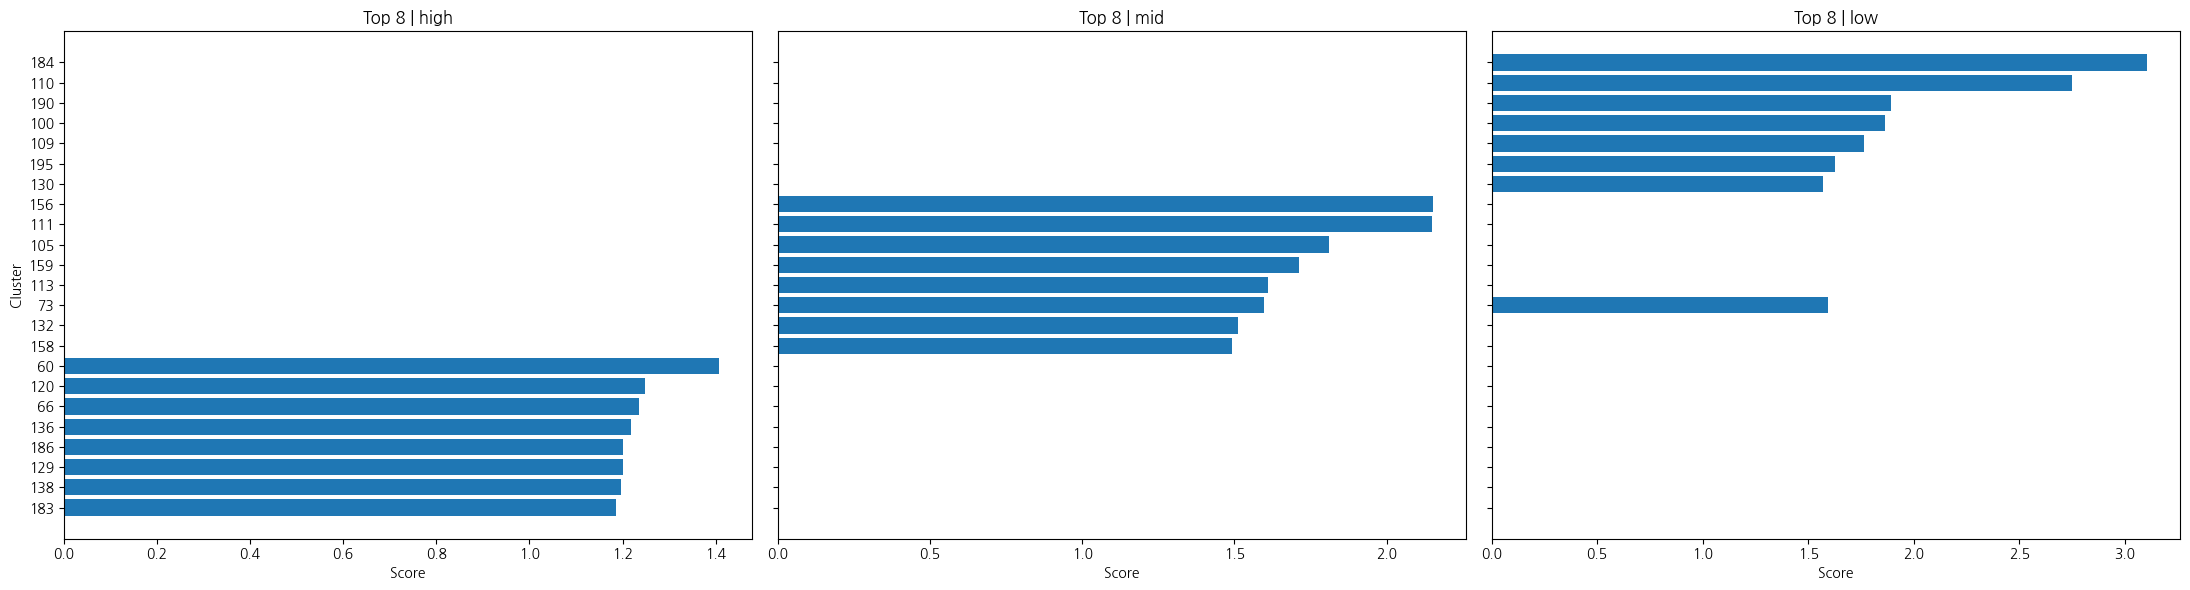

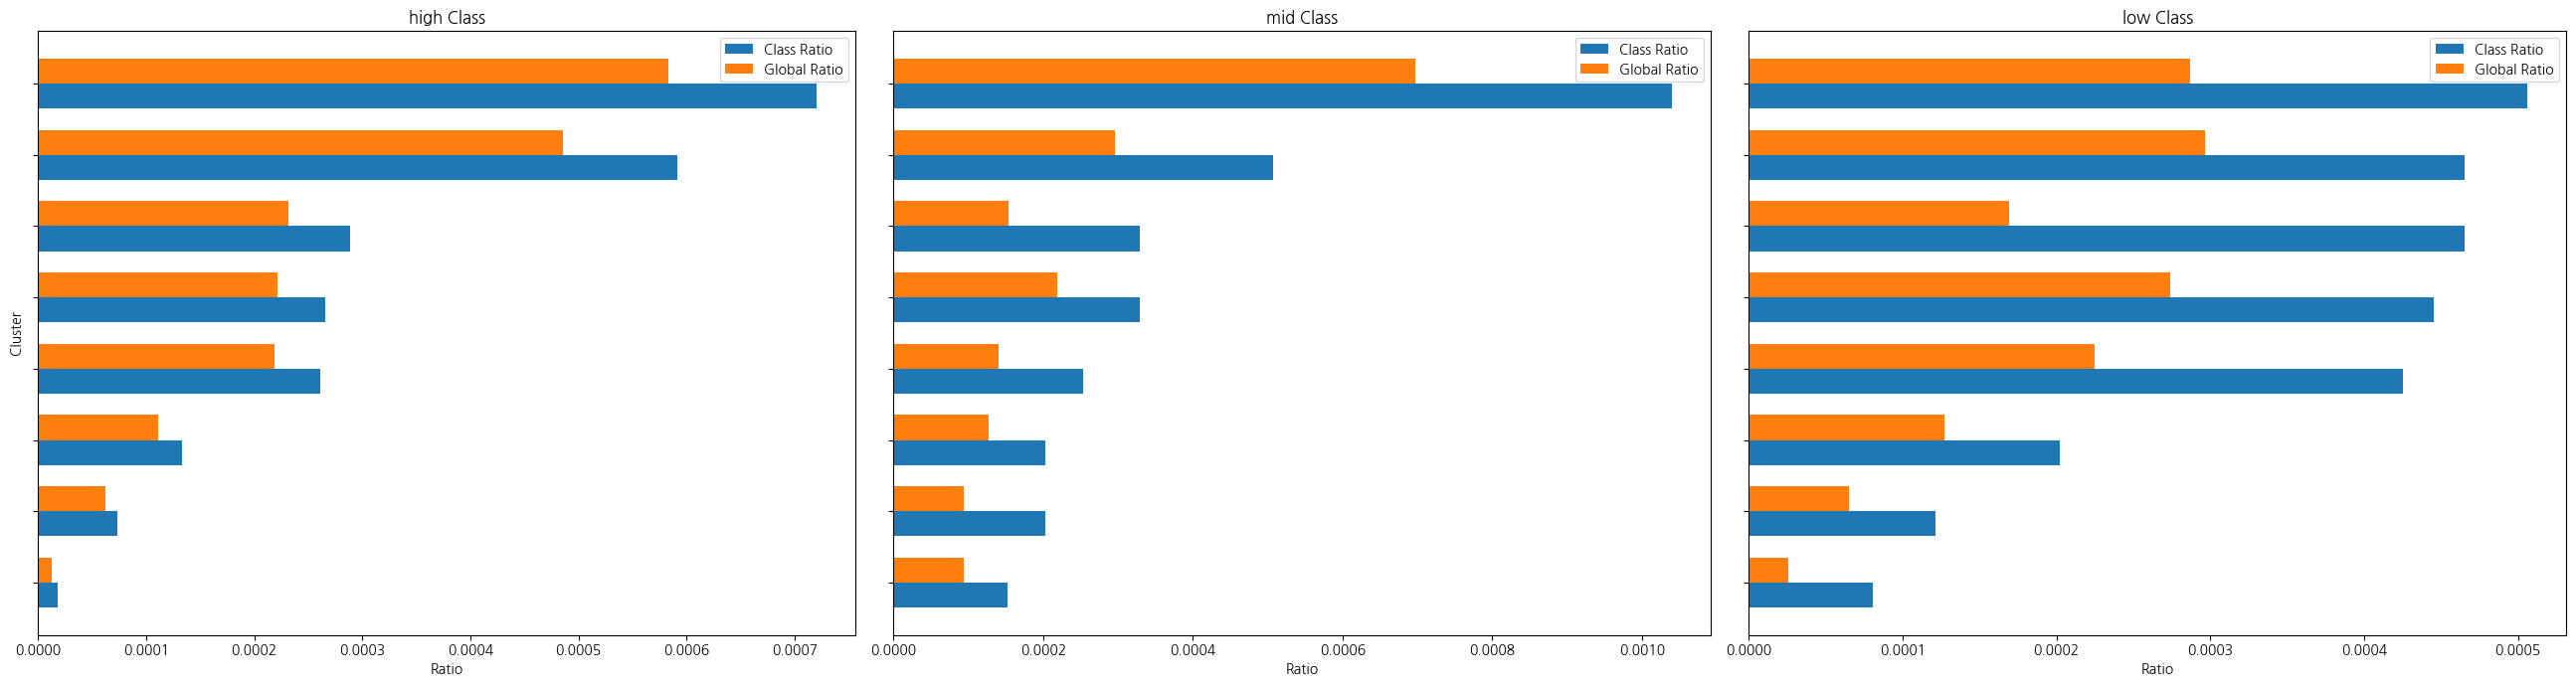

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

df = full_df_eda.copy()

# =====================================
# 1. Rating Class 만들기
# =====================================
def rating_to_class(r):
    if r >= 7:
        return "high"
    elif r == 6 or r == 5:
        return "mid"
    else:
        return "low"

df["rating_class"] = df["rating"].apply(rating_to_class)


# =====================================
# 2. 전체 cluster 등장 비율
# =====================================
cluster_total = df["category_cluster"].value_counts(normalize=True)
# Series: cluster → 전체 등장 확률


# =====================================
# 3. Rating Class 내 cluster 비율 계산
# =====================================


# groupby 두 개를 명시적으로 써서 index 충돌 방지
g = df.groupby(["rating_class", "category_cluster"]).size().reset_index(name="count")

# P(cluster | class)
g["class_ratio"] = g.groupby("rating_class")["count"].transform(lambda x: x / x.sum())

cluster_by_class = g[["rating_class", "category_cluster", "class_ratio"]]



# =====================================
# 4. “클래스 특이성 점수” 계산
#    score = 비율(class) / 비율(overall)
# =====================================
cluster_by_class["global_ratio"] = cluster_by_class["category_cluster"].map(cluster_total)
cluster_by_class["score"] = cluster_by_class["class_ratio"] / cluster_by_class["global_ratio"]


# =====================================
# 5. 각 클래스별 score 기준 top-N cluster 선택
# =====================================
top_n = 8

top_clusters = (
    cluster_by_class
    .sort_values(["rating_class", "score"], ascending=[True, False])
    .groupby("rating_class")
    .head(top_n)
)


# =====================================
# 6-1. Score 기반 수평 Bar Chart (barh)
# =====================================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=True)

for i, cls in enumerate(rating_classes):
    df_cls = top_clusters[top_clusters["rating_class"] == cls].copy()
    df_cls = df_cls.sort_values("score")

    axes[i].barh(
        df_cls["category_cluster"].astype(str),
        df_cls["score"]
    )
    axes[i].set_title(f"Top {top_n} | {cls}")
    axes[i].set_xlabel("Score")
    if i == 0:
        axes[i].set_ylabel("Cluster")

plt.tight_layout()
plt.show()


# 버전 2) class_ratio vs global_ratio 수평 비교 bar chart
fig, axes = plt.subplots(1, 3, figsize=(26, 7), sharey=True)

for i, cls in enumerate(rating_classes):
    df_cls = top_clusters[top_clusters["rating_class"] == cls].copy()
    df_cls = df_cls.sort_values("class_ratio")

    y = np.arange(len(df_cls))
    h = 0.35

    axes[i].barh(y - h/2, df_cls["class_ratio"], h, label="Class Ratio")
    axes[i].barh(y + h/2, df_cls["global_ratio"], h, label="Global Ratio")

    axes[i].set_title(f"{cls} Class")
    axes[i].set_xlabel("Ratio")
    axes[i].set_yticks(y)
    axes[i].set_yticklabels(df_cls["category_cluster"].astype(str))

    if i == 0:
        axes[i].set_ylabel("Cluster")
    else:
        axes[i].set_yticklabels([])

    axes[i].legend()

plt.tight_layout()
plt.show()


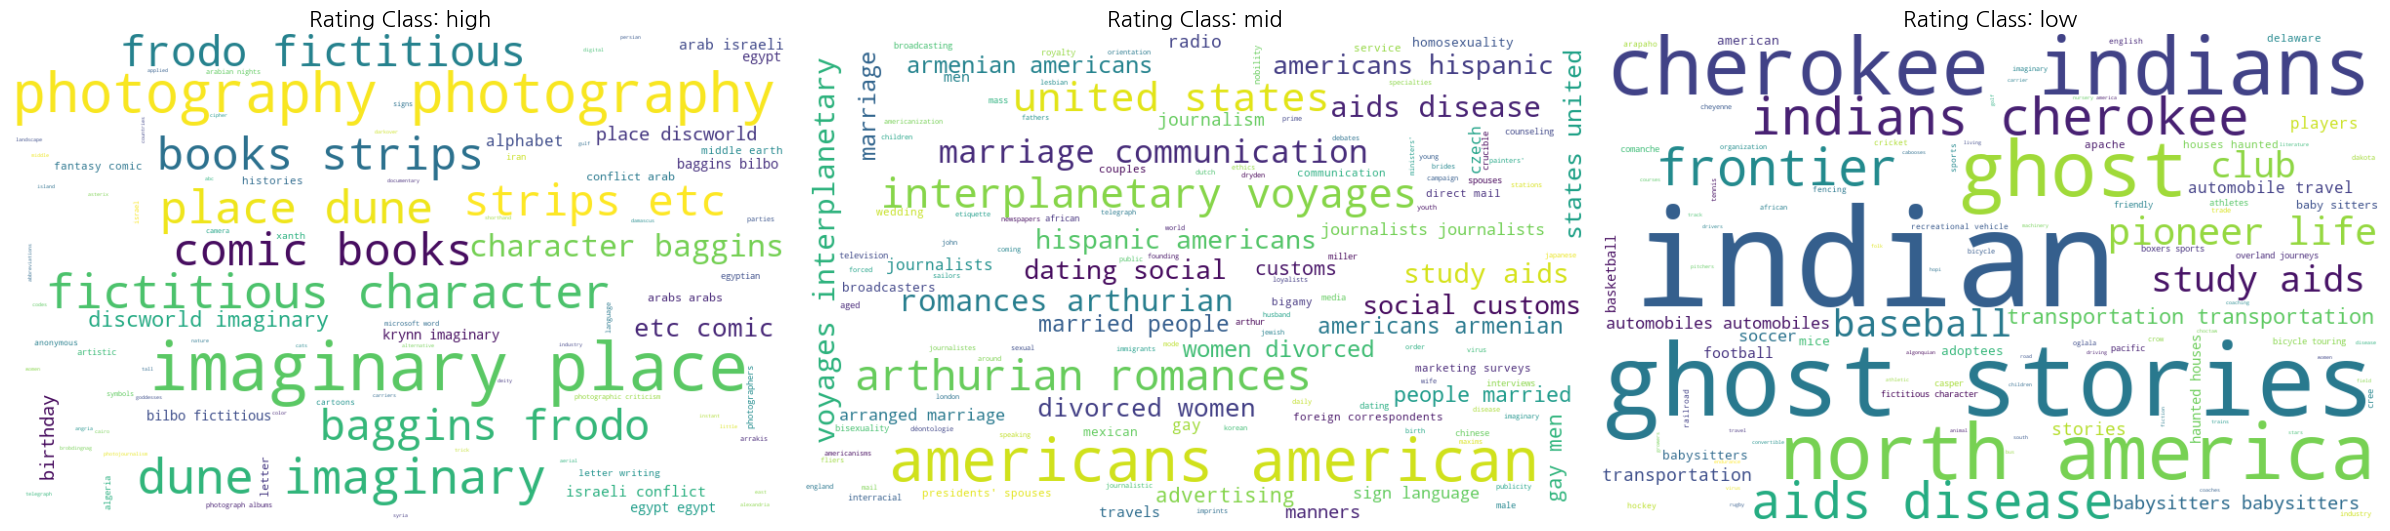

In [50]:
# -------------------------------
# 5. WordCloud 생성 함수
# -------------------------------
def get_cluster_wordcloud(df, cls, top_clusters, text_col="category"):
    """
    특정 rating_class 안에서 score 상위 cluster들의 category 텍스트를 wordcloud로 표시
    """
    # 해당 rating class의 top cluster 목록
    clusters = top_clusters[top_clusters["rating_class"] == cls]["category_cluster"].tolist()

    # 그 cluster에 속한 책들의 category 텍스트 모으기
    text = " ".join(df[df["category_cluster"].isin(clusters)][text_col].tolist())

    # WordCloud 생성
    wc = WordCloud(
        width=800,
        height=500,
        background_color='white',
        colormap='viridis'
    ).generate(text)

    return wc

# -------------------------------
# 6. 3개 클래스를 가로로 WordCloud로
# -------------------------------
rating_classes = ["high", "mid", "low"]

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, cls in enumerate(rating_classes):
    wc = get_cluster_wordcloud(df, cls, top_clusters)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Rating Class: {cls}", fontsize=16)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### book_popluation(book_review_count) 과 rating 관계
- 가설 : 리뷰가 많은 책일 수록 평균 rating 이 높다 -> 리뷰 많으면 맛집 아님?
- book_population 과 category_cluster 관계 : fiction 이 젤 많이 팔리지 않았을까?
- 연령대별 리뷰 많은 책(인기 책) 차이

최대 리뷰 수: 566

=== 리뷰 수 구간별 책 개수 ===
count
0 ~ 99       129680
100 ~ 199        84
200 ~ 299         9
300 ~ 399         2
400 ~ 499         1
500+              1


=== 0~99 리뷰 수 책들을 10단위로 자른 구간별 책 개수 ===
count
0~9      125701
10~19      2571
20~29       677
30~39       297
40~49       180
50~59        95
60~69        57
70~79        59
80~89        27
90~99        16


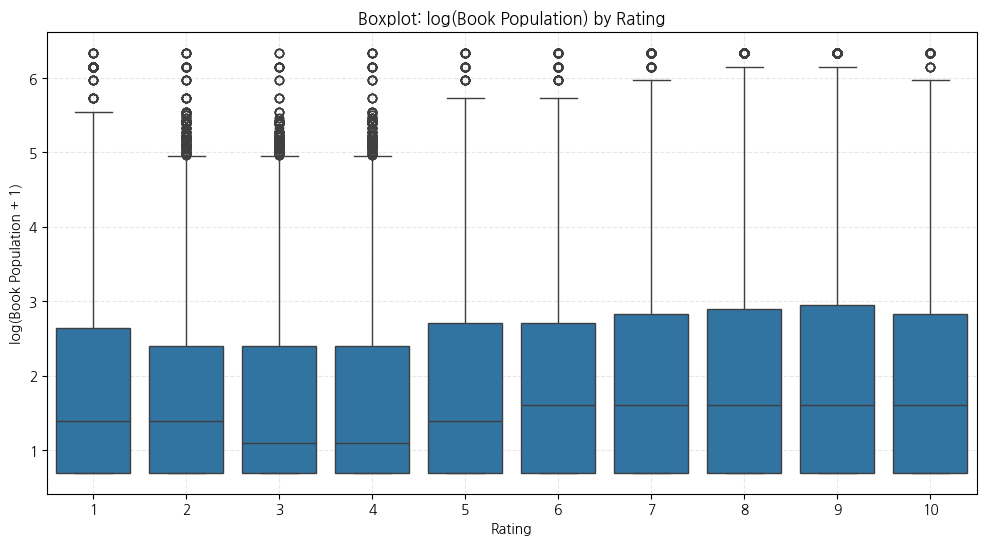

In [64]:
df = full_df_eda.copy()

df["book_population"] = df.groupby("isbn")["user_id"].transform("count")

# -------------------------------
# 1) log 변환
# -------------------------------
df["log_pop"] = np.log1p(df["book_population"])   # log1p = log(x+1)


# -------------------------------
# 3) Boxplot (rating별 log_pop 분포)
# -------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="rating",
    y="log_pop",
    # showfliers=False  # 아웃라이어 너무 많으면 보기가힘듬
)
plt.title("Boxplot: log(Book Population) by Rating")
plt.xlabel("Rating")
plt.ylabel("log(Book Population + 1)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

 => 결과 분석 : 3,4 가 평균이 작다 -> 5,6 으로 갈수록 평균이 커짐 
 => 즉, 점수 낮은 책들이 리뷰수도 작은 경향 
 =>> 그럼 리뷰수 적은 책들이 -> 점수도 낮나? 

### year_of_population 과 rating 관계

=== Year of Publication (Clipped) Summary ===
Count: 306795.0
Min: 1981.0
Q1: 1993.0
Median: 1997.0
Q3: 2001.0
Max: 2005.0
IQR: 8.0
Lower Bound (1.5*IQR rule): 1981.0
Upper Bound (1.5*IQR rule): 2013.0
Number of Outliers: 0
Outlier Ratio: 0.0000


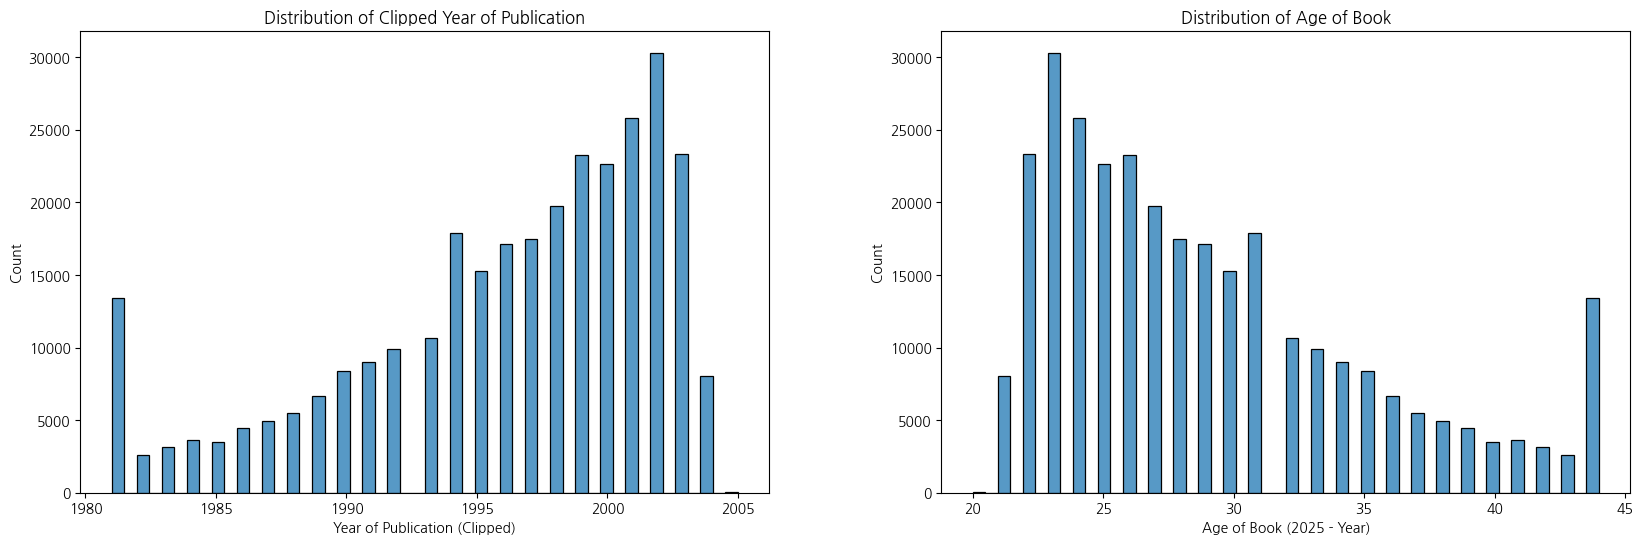

In [91]:
import pandas as pd
import numpy as np

df = full_df_eda.copy()

# -------------------------------
# 1) 이상치 clip
# -------------------------------
Q1 = df["year_of_publication"].quantile(0.25)
Q3 = df["year_of_publication"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df["year_of_publication_clipped"] = df["year_of_publication"].clip(lower=lower_bound, upper=upper_bound)

# -------------------------------
# 2) 결측치 처리
# -------------------------------
mode_year = df["year_of_publication_clipped"].mode()[0]
df["year_of_publication_clipped"] = df["year_of_publication_clipped"].fillna(mode_year)


# -------------------------------
# 3) 최근성 강조: age_of_book
# -------------------------------
df["age_of_book"] = 2025 - df["year_of_publication_clipped"]

# -------------------------------
# 4) 분포 확인
# -------------------------------
summary = df["year_of_publication_clipped"].describe()
Q1 = summary['25%']
median = summary['50%']
Q3 = summary['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
outliers = df[(df["year_of_publication_clipped"] < lower_bound) | (df["year_of_publication_clipped"] > upper_bound)]

print("=== Year of Publication (Clipped) Summary ===")
print(f"Count: {summary['count']}")
print(f"Min: {summary['min']}")
print(f"Q1: {Q1}")
print(f"Median: {median}")
print(f"Q3: {Q3}")
print(f"Max: {summary['max']}")
print(f"IQR: {IQR}")
print(f"Lower Bound (1.5*IQR rule): {lower_bound}")
print(f"Upper Bound (1.5*IQR rule): {upper_bound}")
print(f"Number of Outliers: {len(outliers)}")
print(f"Outlier Ratio: {len(outliers)/len(df):.4f}")

# -------------------------------
# 5) 히스토그램 시각화
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.subplots_adjust(wspace=0.25)

# -------------------------------
# 1) Year of Publication (Clipped)
# -------------------------------
sns.histplot(
    df["year_of_publication_clipped"],
    bins=50,
    kde=False,
    ax=axes[0]
)
axes[0].set_xlabel("Year of Publication (Clipped)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Clipped Year of Publication")

# -------------------------------
# 2) Age of Book
# -------------------------------
sns.histplot(
    df["age_of_book"],
    bins=50,
    kde=False,
    ax=axes[1]
)
axes[1].set_xlabel("Age of Book (2025 - Year)")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Age of Book")

plt.show()



<Axes: title={'center': 'Population Distribution (Log)'}, xlabel='Book Age (years)', ylabel='Population'>

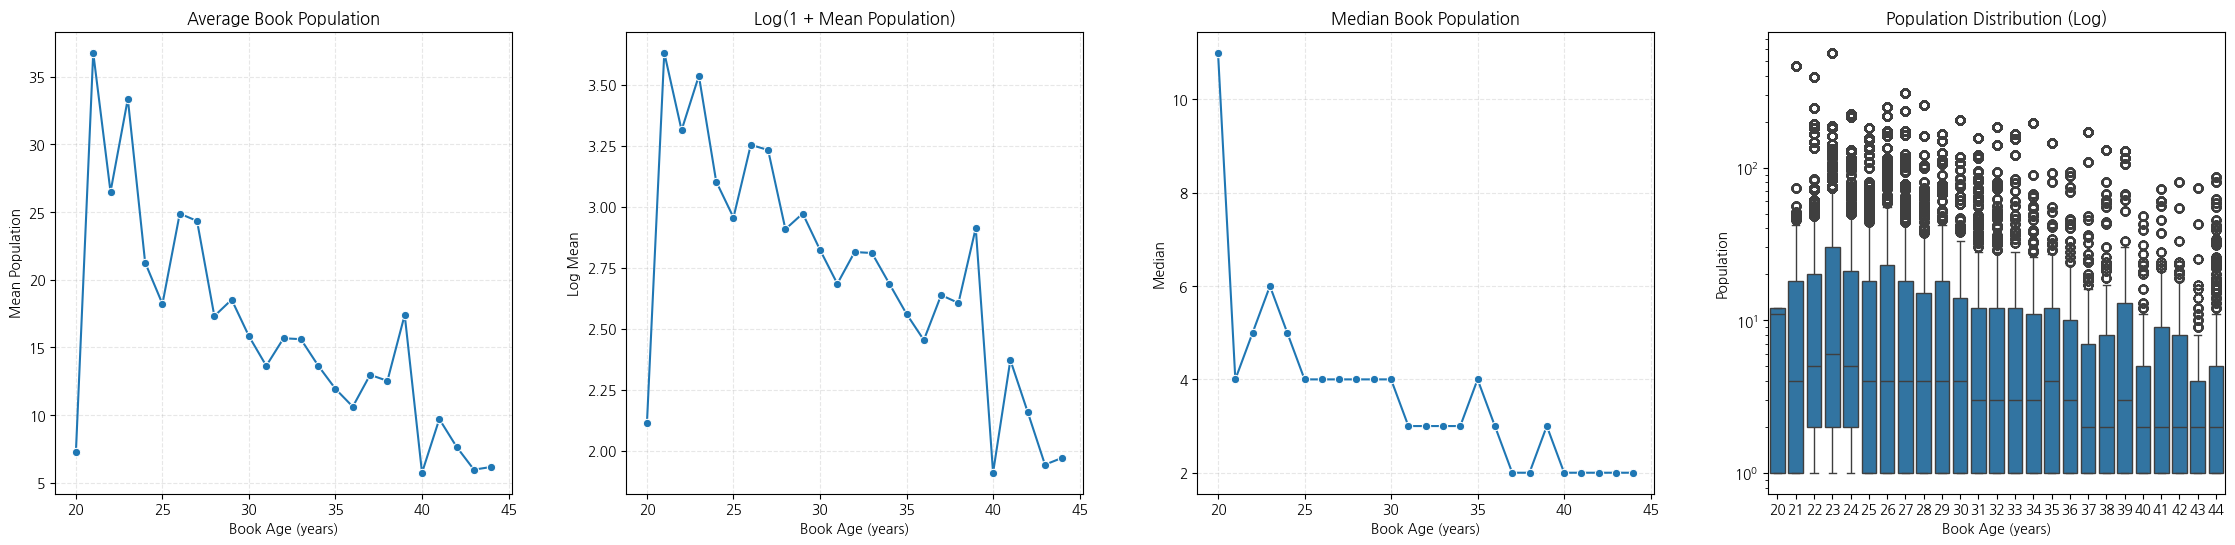

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------------------
# 기존 데이터 처리 부분 그대로 유지
# -------------------------------
df["book_age"] = df["age_of_book"]
df["book_population"] = df.groupby("isbn")["user_id"].transform("count")
df["book_age_int"] = df["book_age"].astype(int)

age_review_stats = (
    df.groupby("book_age_int")["book_population"]
    .agg(
        mean_review="mean",
        median_review="median"
    )
    .reset_index()
)
age_review_stats["log_mean_review"] = np.log1p(age_review_stats["mean_review"])
age_review_stats["log_median_review"] = np.log1p(age_review_stats["median_review"])

bin_width = 2
max_age = df["book_age_int"].max()
min_age = df["book_age_int"].min()
bins = list(range(min_age, max_age + bin_width, bin_width))
labels = [f"{b}-{b+bin_width-1}" for b in bins[:-1]]
df["age_bin"] = pd.cut(df["book_age_int"], bins=bins, labels=labels, right=False)


# -------------------------------
# 4) 시각화를 가로로 배치
# -------------------------------
fig, axes = plt.subplots(1, 4, figsize=(28, 6))
plt.subplots_adjust(wspace=0.25)

# 4-1) mean
sns.lineplot(
    data=age_review_stats,
    x="book_age_int",
    y="mean_review",
    marker="o",
    ax=axes[0]
)
axes[0].set_title("Average Book Population")
axes[0].set_xlabel("Book Age (years)")
axes[0].set_ylabel("Mean Population")
axes[0].grid(True, linestyle="--", alpha=0.3)

# 4-2) log mean
sns.lineplot(
    data=age_review_stats,
    x="book_age_int",
    y="log_mean_review",
    marker="o",
    ax=axes[1]
)
axes[1].set_title("Log(1 + Mean Population)")
axes[1].set_xlabel("Book Age (years)")
axes[1].set_ylabel("Log Mean")
axes[1].grid(True, linestyle="--", alpha=0.3)

# 4-3) median
sns.lineplot(
    data=age_review_stats,
    x="book_age_int",
    y="median_review",
    marker="o",
    ax=axes[2]
)
axes[2].set_title("Median Book Population")
axes[2].set_xlabel("Book Age (years)")
axes[2].set_ylabel("Median")
axes[2].grid(True, linestyle="--", alpha=0.3)

# 4-4) boxplot (log scale)
sns.boxplot(
    data=df,
    x="book_age_int",
    y="book_population",
    ax=axes[3]
)
axes[3].set_yscale("log")
axes[3].set_title("Population Distribution (Log)")
axes[3].set_xlabel("Book Age (years)")
axes[3].set_ylabel("Population")
axes[3]


In [ ]:
import numpy as np
import pandas as pd

df = full_df_eda.copy()


# ==================================================
# 1) year_of_publication → IQR 기반 clip
# ==================================================
Q1 = df["year_of_publication"].quantile(0.25)
Q3 = df["year_of_publication"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound,upper_bound)
# clip + 결측치 최빈값 처리
year_clipped = df["year_of_publication"].clip(lower=lower_bound, upper=upper_bound)

mode_year = year_clipped.mode()[0]
year_clipped = year_clipped.fillna(mode_year)


# ==================================================
# 2) age_of_book (중간 컬럼 없이 바로 생성)
# ==================================================
df["age_of_book"] = 2025 - year_clipped


# ==================================================
# 3) book_population_log_clipped (중간 컬럼 생성 없음)
# ==================================================
book_pop = df.groupby("isbn")["user_id"].transform("count")

df["book_population_log_clipped"] = np.log1p(book_pop.clip(upper=100))


# ==================================================
# full_df_eda 업데이트
# ==================================================
full_df_eda = df.copy()

print("full_df_eda 추가된 컬럼:", ["age_of_book", "book_population_log_clipped"],"clip 통한 전처리도")


1981.0 2013.0
full_df_eda 추가된 컬럼: ['age_of_book', 'book_population_log_clipped'] clip 통한 전처리도


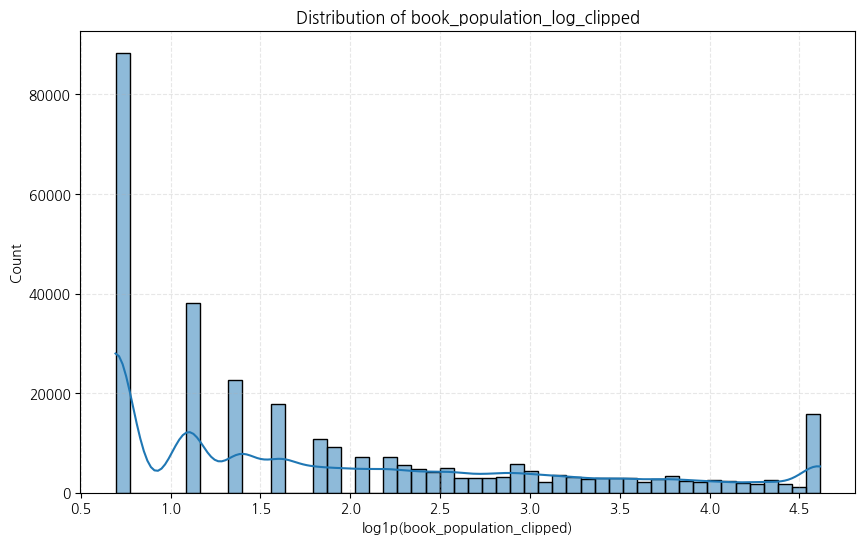

In [93]:
plt.figure(figsize=(10,6))
sns.histplot(df["book_population_log_clipped"], bins=50, kde=True)
plt.xlabel("log1p(book_population_clipped)")
plt.ylabel("Count")
plt.title("Distribution of book_population_log_clipped")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

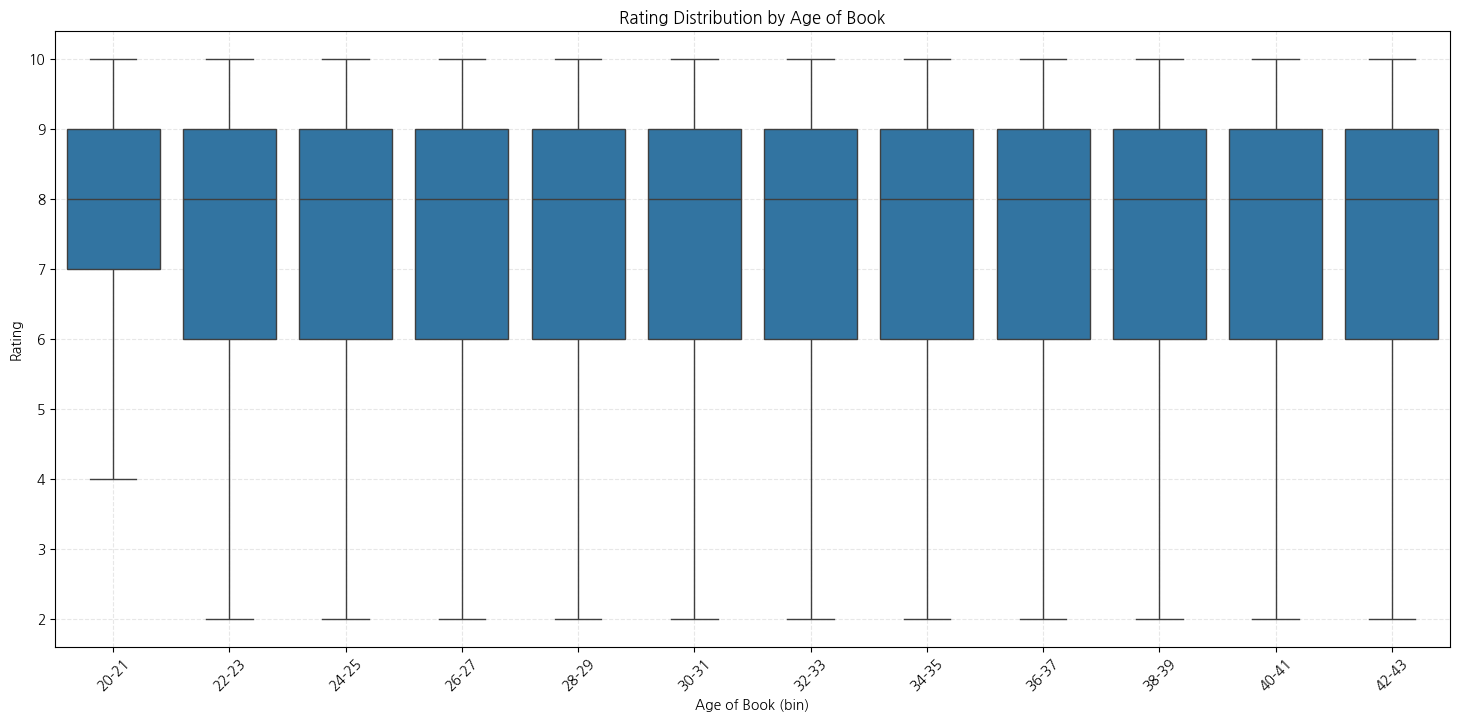

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# age bin 생성 (2년 단위)
# -------------------------------
bin_width = 2
min_age = int(df["age_of_book"].min())
max_age = int(df["age_of_book"].max())

age_bins = list(range(min_age, max_age + bin_width, bin_width))
age_labels = [f"{b}-{b+bin_width-1}" for b in age_bins[:-1]]

df["age_bin"] = pd.cut(df["age_of_book"], bins=age_bins, labels=age_labels, right=False)

# -------------------------------
# 박스플롯 시각화
# -------------------------------
plt.figure(figsize=(18, 8))
sns.boxplot(
    data=df,
    x="age_bin",
    y="rating",
    showfliers=False
)
plt.xticks(rotation=45)
plt.xlabel("Age of Book (bin)")
plt.ylabel("Rating")
plt.title("Rating Distribution by Age of Book")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


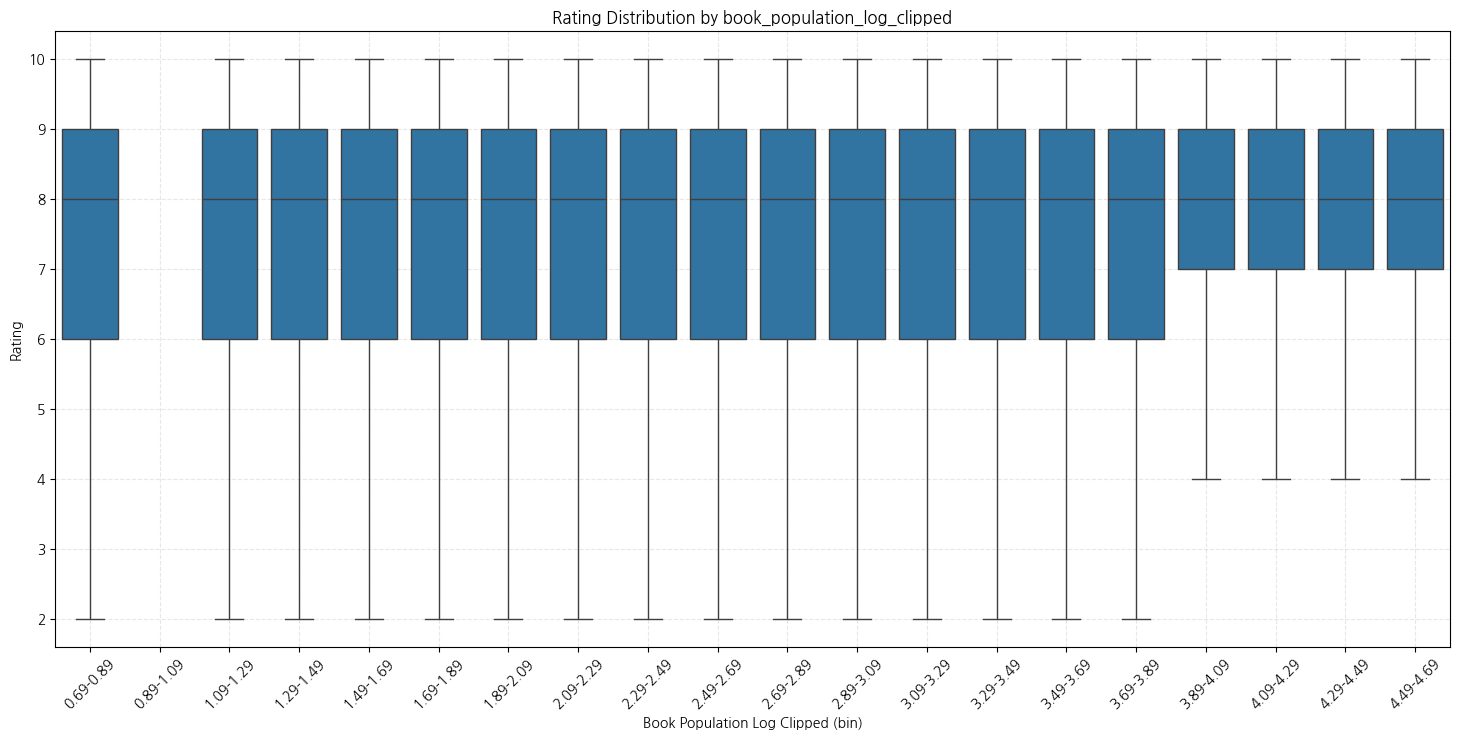

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# bin 생성 (2 단위)
# -------------------------------
bin_width = 0.2

min_val = float(df["book_population_log_clipped"].min())
max_val = float(df["book_population_log_clipped"].max())

pop_bins = list(np.arange(min_val, max_val + bin_width, bin_width))
pop_labels = [f"{round(b,2)}-{round(b+bin_width,2)}" for b in pop_bins[:-1]]

df["pop_bin"] = pd.cut(df["book_population_log_clipped"], bins=pop_bins, labels=pop_labels, right=False)

# -------------------------------
# 박스플롯 시각화
# -------------------------------
plt.figure(figsize=(18, 8))
sns.boxplot(
    data=df,
    x="pop_bin",
    y="rating",
    showfliers=False
)
plt.xticks(rotation=45)
plt.xlabel("Book Population Log Clipped (bin)")
plt.ylabel("Rating")
plt.title("Rating Distribution by book_population_log_clipped")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


### 책 독자의 연령대 피쳐 (학습 시 leakage 가능성 있으므로 -> train/valid 로 나눠서 만들기 *지금은 EDA 중이라 ㄱㅊ)
- age -> group 화 but 결측치 어째? => 결측인 user 데이터 특징 뽑기
- 평균 독자 나이가 높은 책 -> 어떤책?
- 평균 독자 나이가 낮은 책 -> 어떤 책?
- 평균 독자 나이 vs rating 관계

In [120]:
# ... 위에 너가 만든 코드들 그대로 두고

# 3) age_group → 숫자화
age_group_to_num = {
    "17-25": 21,
    "26-35": 30,
    "36-45": 40,
    "46-55": 50,
    "56-61": 59
}
df["age_group_num"] = df["age_group"].map(age_group_to_num)

# ⭐⭐ category로 잡혀버려서 mean 불가 → float로 변환 ⭐⭐
df["age_group_num"] = df["age_group_num"].astype(float)

# 4) 책별 평균 독자연령대 피쳐 생성
book_mean_reader_age = (
    df.groupby("isbn")["age_group_num"]
      .mean()
      .rename("book_mean_reader_age")
)

df = df.merge(book_mean_reader_age, on="isbn", how="left")

full_df_eda = df.copy()


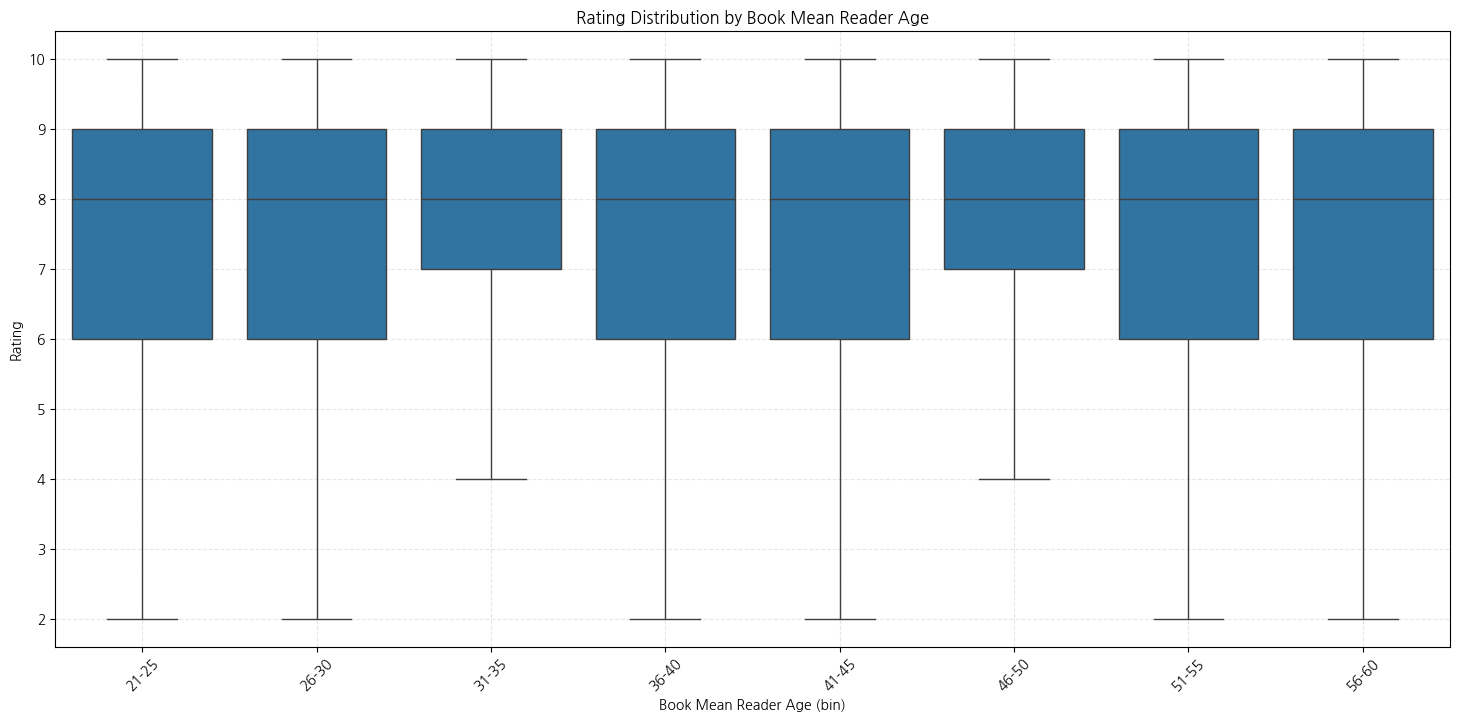

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = full_df_eda.copy()

# -------------------------------
# 1) binning (5살 단위)
# -------------------------------
bin_width = 5

min_age = int(df["book_mean_reader_age"].min())
max_age = int(df["book_mean_reader_age"].max())

bins = list(range(min_age, max_age + bin_width, bin_width))
labels = [f"{b}-{b+bin_width-1}" for b in bins[:-1]]

df["mean_reader_age_bin"] = pd.cut(df["book_mean_reader_age"], bins=bins, labels=labels, right=False)

# -------------------------------
# 2) Boxplot: book_mean_reader_age_bin vs rating
# -------------------------------
plt.figure(figsize=(18, 8))
sns.boxplot(
    data=df,
    x="mean_reader_age_bin",
    y="rating",
    showfliers=False
)

plt.xticks(rotation=45)
plt.xlabel("Book Mean Reader Age (bin)")
plt.ylabel("Rating")
plt.title("Rating Distribution by Book Mean Reader Age")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


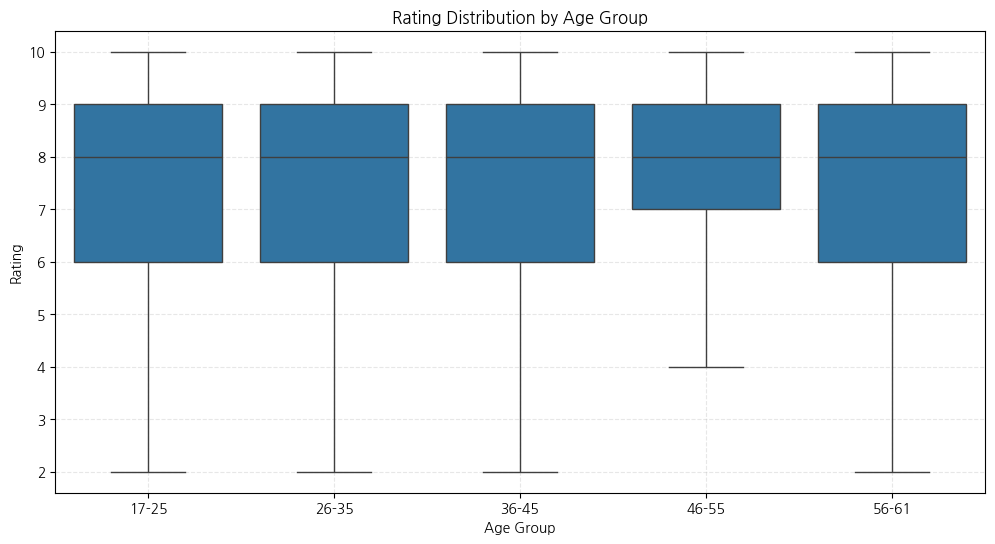

In [124]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=full_df_eda,
    x="age_group",
    y="rating",
    showfliers=False
)
plt.xlabel("Age Group")
plt.ylabel("Rating")
plt.title("Rating Distribution by Age Group")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


### 같은 책인데 출판사 땜에 다른 책 된 애들